In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time
import datetime

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average



2024-11-07 01:15:05.065800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 01:15:05.065895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 01:15:05.068440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.15.0


In [2]:
#data_path = "outlineOutput"
#data_path = "H:\\download\\blender\\projects\\vdmTests\\outlineOutput"
#output_path = "H:\\tmp\\dexined"
data_path = "/media/Tomasz/4T/work/dexined/outlineOutput"
output_path = "/media/Tomasz/4T/work/dexined/tmp/teed"

train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)


/media/Tomasz/4T/work/dexined/outlineOutput/test_edge/*


In [3]:
def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

In [4]:
images, edges = load_data(train_path, edge_train_path)
valimg, valedg = load_data(val_path, edge_val_path)
#print(len(images), len(edges))

In [5]:
#print(len(testimg), len(testedg))

In [6]:
def read_image(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

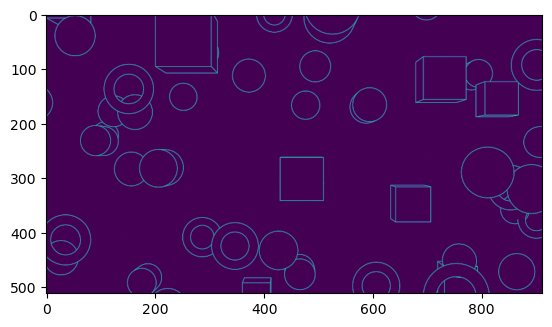

In [7]:

img = read_edge(data_path+"/train_edge/dense_000.png", H=512, W=912)
plt.imshow(img)

In [8]:
def preprocess(x,y,H=512, W=912):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

In [9]:
def tf_data(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=100)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(32)
    data = data.prefetch(buffer_size=f.dtata.experimental.AUTOTUNE)
    return data


In [10]:
train_data = tf_data(images, edges)
val_data = tf_data(valimg, valedg)

2024-11-07 01:15:23.661811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:15:23.670480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:15:23.670638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:15:23.672269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 01:15:23.672422: I external/local_xla/xla/stream_executor

In [11]:
#for x, y in train_data:
#  print(x.shape, y.shape)
#
print(len(train_data),len(val_data))


1269 131


In [12]:
weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.L2(0.01)
w_decay=1e-3

glorot_normal = RandomNormal(stddev=0.01)

In [13]:
self_conv2D_1 = Conv2D(16 , kernel_size=(3,3),strides=(2,2),padding = 'same')
self_activation_1 = Activation(activation='sigmoid')
self_activation_15 = Activation(activation='log_softmax')
self_activation_8 = Activation(activation='tanh')
self_conv2D_2 = Conv2D(16 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_25 = Activation(activation='sigmoid')
self_activation_9 = Activation(activation='log_softmax')
self_activation_11 = Activation(activation='tanh')
self_conv2D_3 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_5 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True)
self_conv2D_10 = Conv2D(32 , kernel_size=(1,1),strides=(2,2),padding = 'same')
self_activation_2 = Activation(activation='sigmoid')
self_activation_22 = Activation(activation='sigmoid')
self_activation_13 = Activation(activation='log_softmax')
self_activation_16 = Activation(activation='log_softmax')
self_activation_14 = Activation(activation='tanh')
self_activation_7 = Activation(activation='tanh')
self_conv2D_4 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_transpoze2D_1 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_14 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True)
self_maxpool2D_1 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_activation_12 = Activation(activation='sigmoid')

self_conv2D_11 = Conv2D(48 , kernel_size=(1,1),strides=(1,1),padding = 'same')
self_activation_5 = Activation(activation='log_softmax')
self_conv2D_12 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_6 = Activation(activation='tanh')
self_activation_18 = Activation(activation='sigmoid')
self_transpoze2D_4 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True)
self_activation_27 = Activation(activation='log_softmax')
self_activation_3 = Activation(activation='tanh')
self_conv2D_13 = Conv2D(48 , kernel_size=(3,3),strides=(1,1),padding = 'same')

self_conv2D_6 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True)
self_activation_17 = Activation(activation='sigmoid')
self_activation_19 = Activation(activation='log_softmax')
self_activation_10 = Activation(activation='tanh')
self_transpoze2D_2 = Conv2DTranspose(16 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_7 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True)
self_activation_20 = Activation(activation='sigmoid')
self_activation_21 = Activation(activation='log_softmax')
self_activation_4 = Activation(activation='tanh')
self_transpoze2D_3 = Conv2DTranspose(1 , kernel_size=(4,4),strides=(2,2),padding = 'same',use_bias=True)

self_conv2D_8 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_9 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_23 = Activation(activation='sigmoid')
self_activation_24 = Activation(activation='log_softmax')
self_activation_26 = Activation(activation='tanh')

self_concatenate_1 = Concatenate(axis=3)



x = Input(shape=(512,912,3))
conv2D_1 = self_conv2D_1(x)
activation_1 = self_activation_1(conv2D_1)
activation_15 = self_activation_15(activation_1)
activation_8 = self_activation_8(activation_15)
conv2D_2 = self_conv2D_2(activation_8)
activation_25 = self_activation_25(conv2D_2)
activation_9 = self_activation_9(activation_25)
activation_11 = self_activation_11(activation_9)
conv2D_3 = self_conv2D_3(activation_11)
conv2D_5 = self_conv2D_5(activation_11)
conv2D_10 = self_conv2D_10(activation_11)
activation_2 = self_activation_2(conv2D_3)
activation_22 = self_activation_22(conv2D_5)
activation_13 = self_activation_13(activation_2)
activation_16 = self_activation_16(activation_22)
activation_14 = self_activation_14(activation_13)
activation_7 = self_activation_7(activation_16)
conv2D_4 = self_conv2D_4(activation_14)
transpoze2D_1 = self_transpoze2D_1(activation_7)
conv2D_14 = self_conv2D_14(conv2D_4)
maxpool2D_1 = self_maxpool2D_1(conv2D_4)
activation_12 = self_activation_12(conv2D_14)
add_1 = Add()([conv2D_10,maxpool2D_1])
conv2D_11 = self_conv2D_11(maxpool2D_1)
activation_5 = self_activation_5(activation_12)
conv2D_12 = self_conv2D_12(add_1)
activation_6 = self_activation_6(activation_5)
activation_18 = self_activation_18(conv2D_12)
transpoze2D_4 = self_transpoze2D_4(activation_6)
activation_27 = self_activation_27(activation_18)
activation_3 = self_activation_3(activation_27)
conv2D_13 = self_conv2D_13(activation_3)
average_1 = Average()([conv2D_11,conv2D_13])
conv2D_6 = self_conv2D_6(average_1)
activation_17 = self_activation_17(conv2D_6)
activation_19 = self_activation_19(activation_17)
activation_10 = self_activation_10(activation_19)
transpoze2D_2 = self_transpoze2D_2(activation_10)
conv2D_7 = self_conv2D_7(transpoze2D_2)
activation_20 = self_activation_20(conv2D_7)
activation_21 = self_activation_21(activation_20)
activation_4 = self_activation_4(activation_21)
transpoze2D_3 = self_transpoze2D_3(activation_4)


tmp = [transpoze2D_1,transpoze2D_3,transpoze2D_4]
concatenate_1 = self_concatenate_1(tmp)
conv2D_8 = self_conv2D_8(concatenate_1)
conv2D_9 = self_conv2D_9(conv2D_8)
activation_23 = self_activation_23(conv2D_9)
activation_24 = self_activation_24(activation_23)
activation_26 = self_activation_26(activation_24)

model = keras.Model(inputs =x , outputs=activation_26)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 912, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 456, 16)         448       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 456, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 activation_1 (Activation)   (None, 256, 456, 16)         0         ['activation[0][0]']          
                                                                                              

In [15]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives()], run_eagerly=True)

In [16]:
checkpoint = ModelCheckpoint(output_path+"/best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

In [17]:
log_dir = output_path+"/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
train_steps=len(train_data)
val_steps=len(val_data)
print(train_steps,val_steps)
model.fit(train_data, validation_data=val_data, epochs=12, steps_per_epoch=train_steps, validation_steps=val_steps)

1269 131
Epoch 1/12


2024-11-07 01:16:04.534110: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 8904
2024-11-07 01:23:10.333250: I external/local_xla/xla/service/service.cc:168] XLA service 0xaaab0fd12da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 01:23:10.333365: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Orin, Compute Capability 8.7
2024-11-07 01:23:10.368753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730938990.582739  873101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


ValueError: Shapes (32, 512, 912, 24) and (32, 512, 912, 1) are incompatible

In [ ]:
img_pre = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test\\dense_981.png')
img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:
img_e = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test_edge\\dense_981.png')
#img = np.expand_dims(img, axis=0)
plt.imshow(img_e)

In [ ]:
#model.load_weights("H:\\tmp\\dexined\\checkpoint_dir\\dexined_tryepochs\\DexiNed10_model.h5")
res_pre = model.predict(img)
res = res_pre[-1,:,:]
plt.imshow(res)

In [ ]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

In [ ]:
import cv2
res2=res
res2[res2 < 0.0] = 0.0
out=cv2.bitwise_not(np.uint8(image_normalization(res2)))
plt.imshow(out, cmap='gray')